In [45]:
%pylab inline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption
from tools import to_timeseries
from tools import split_train_test

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH = 32

# Data

In [21]:
dataset, data_x, data_y = load_household_power_consumption()

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(to_timeseries(data_x, t=BATCH), 
                                                    to_timeseries(data_y, t=BATCH), 
                                                    train_ratio=0.8)
print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-16 11:10:24,291 [hybrid-lstm.tool | INFO] Load existing dataset


data_x: (43642, 7)
data_y: (43642, 1)
train_x: (34863, 32, 7)
train_y: (34863, 32, 1)
test_x: (8716, 32, 7)
test_y: (8716, 32, 1)


# Models

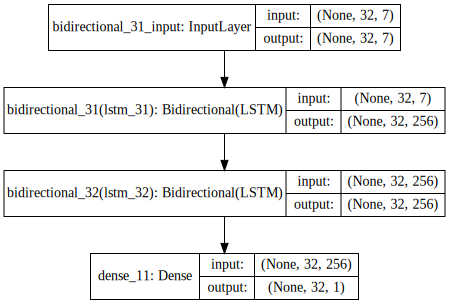

In [43]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_model(l1=64, l2=64):
    np.random.seed(0)
    model = Sequential()
    model.add(Bidirectional(LSTM(l1, return_sequences=True), input_shape=(BATCH, 7)))
    model.add(Bidirectional(LSTM(l1, return_sequences=True)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', coeff_determination])
    return model

model = create_model(128, 128)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [ ]:
model = create_model(l1=128, l2=128)

history = History()
model.fit(train_x, train_y, epochs=100, batch_size=BATCH, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 34863 samples, validate on 8716 samples
Epoch 1/100


In [25]:
model.evaluate(test_x, test_y)

8716/8716 [==============================] - 13s      

[4.496346461630357e-05, 0.00011473152822395595]

[1885] r^2: -86.15      
[7743] r^2: -102.4      
[1845] r^2: -99.5       
[5298] r^2: -339.4      
[1001] r^2: -44.63      
[8491] r^2: -22.23      
[2607] r^2: -280.4      
[8024] r^2: -333.8      
[105 ] r^2: -137.0      
[4970] r^2: -37.87      
[1600] r^2: -11.97      
[5006] r^2: -61.73      
[6614] r^2: -2.439      
[8458] r^2: -21.49      
[2257] r^2: -5.751      
[4036] r^2: -14.91      


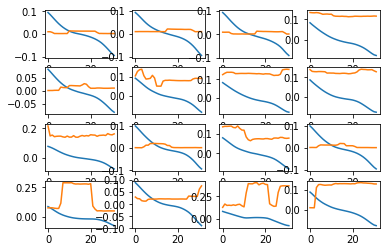

In [58]:
def vis_evaluate(model, test_x, test_y):
    n = len(test_x)
    
    fig, plots = subplots(4, 4)
    plots = plots.reshape(-1)
    
    for p in plots:
        idx = np.random.randint(0, n)
        true_y = test_y[idx]
        pred_y = model.predict(test_x[idx:idx+1])
        
        score = r2_score(true_y.reshape(-1), pred_y.reshape(-1))
        print(f'[{idx:<4}] r^2: {score:<12.4}')

        p.plot(pred_y[0])
        p.plot(true_y)

vis_evaluate(model, test_x, test_y)